In [3]:
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from IPython.display import clear_output
from matplotlib.pyplot import *
import networkx as nx

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cpu")

In [29]:
class FastSlowMixture(torch.nn.Module):
    def __init__(self, dimension, rho):
        """
        The Model parameters.
        """
        super().__init__()

        self.l1 = torch.nn.Parameter(torch.empty(30, dimension))
        torch.nn.init.kaiming_uniform_(self.l1, a=5**0.5)

        self.l2 = torch.nn.Parameter(torch.empty(10, 30))
        torch.nn.init.kaiming_uniform_(self.l2, a=5**0.5)

        self.l3 = torch.nn.Parameter(torch.empty(1, 10))
        torch.nn.init.kaiming_uniform_(self.l3, a=5**0.5)

        self.a2 = torch.nn.ReLU()
        self.a1 = torch.nn.ReLU()

        self.rho = rho

    def forward(self, x, is_cold=True):

        temp = self.rho * (1. - is_cold) + is_cold

        out = x 
        out = torch.nn.functional.linear(out, temp * self.l1)
        out = self.a1(out)
        out = torch.nn.functional.linear(out, temp * self.l2)
        out = self.a2(out)
        out = torch.nn.functional.linear(out, temp * self.l3)

        return out



In [80]:
def int_to_binary(num, length):
  bin_str = bin(num)[2:]
  
  # Pad the binary string with leading zeros as necessary
  bin_str = '{:0>{}}'.format(bin_str, length)
  
  # Convert the binary string to a binary vector
  return torch.tensor([2*int(digit) - 1. for digit in bin_str])

def P_value(cut_value, d, n):
   return (cut_value/n - d/4.) / (d/4.)**(0.5)

def max_cut_loss(log_density, score, reg_value=0.):

    probs = probs_from_logits(log_density)
    log_density = (log_density - torch.max(log_density)).detach()


    loss = - torch.sum(score * probs) 

    ent_reg =  reg_value * torch.sum(log_density * probs) 

    return loss + ent_reg

def probs_from_logits(logits):
   tmp = logits - torch.max(logits)
   probs = torch.exp(tmp)
   probs = probs/torch.sum(probs)
   return probs

In [81]:
def vanilla_cut_optimizer(net, opt, iterations, X, y):
    losses_vanilla = []
    out = None
  
    for step in range(iterations):
        net.train()
        opt.zero_grad()

        out = net(X).squeeze()
        probs = probs_from_logits(out)
        loss = -torch.sum(probs * y)

        if step % 10 == 0:
            print("Step", step, "Cut Score", -loss.item())
        
        loss.backward()
        
        opt.step()
        losses_vanilla.append(-loss.detach())
    return out, losses_vanilla


In [82]:
def hot_cold_cut_optimizer(net, opt, iterations, L, 
                           reg_value, reg_updates, reg_scaling, 
                           mix_prob, X, y):
    losses_regularized = []
    cold_out = None

    new_reg_value = reg_value
    iter_split = np.array_split(np.array(range(iterations)), reg_updates)

    total_iterations = 0
    
    for x in iter_split:
      reg_iterations = len(x)
      new_reg_value = new_reg_value / reg_scaling

      for step in range(reg_iterations):
        net.train()
        opt.zero_grad()

        cold_out = net(X).squeeze() 
        cold_probs = probs_from_logits(cold_out)
        mean_score = torch.sum(y*cold_probs).item()

        hot_out = net(X, is_cold=False).squeeze() 
        probs_hot = probs_from_logits(hot_out)
        mean_score_hot = torch.sum(probs_hot * y).item()

        if (step + total_iterations) % 10 == 0:
          print("Step", step + total_iterations, "The score of cold samples", mean_score)
          print("Step", step + total_iterations, "The score of hot samples ", mean_score_hot)

        loss = max_cut_loss(cold_out, y, reg_value=new_reg_value)
        loss_hot = max_cut_loss(hot_out, y, reg_value=new_reg_value)

        loss = (1-mix_prob) * loss + mix_prob * loss_hot

        loss.backward()
        
        opt.step()


    
        losses_regularized.append(mean_score)
      total_iterations += reg_iterations 
    return cold_out, losses_regularized


In [93]:
trials = 20
dimension = 15
iterations_vanilla = 1000
iterations_regularized = 1000
step_size = 0.003
find_opt = True
new_reg_value = 2.
reg_updates = 6
reg_scaling = 1.5
mix_prob = 0.2
rho = 0.03

optimal_values = []
vanilla_trajectories = []

vanilla_scores = []
reg_trajectories = []

reg_scores = []
cut_value_list = []

for j in range(trials):
  G = nx.to_numpy_array(
      nx.generators.random_graphs.gnp_random_graph(dimension, 0.5)).astype(int)
      # nx.generators.random_graphs.random_regular_graph(degree, dimension)).astype(int)
  
    
  Gt = torch.tensor(G, dtype=torch.float)

  L = (torch.diag(torch.sum(Gt, axis=1)) - Gt).to(device)
  degree = torch.mean(torch.diag(L))
  print("Avg Degree", degree)

  if find_opt:

    def s(n):
        return np.array( [int(x) for x in bin(2**dimension + n)[2:]][1:] )
    def cut(n):
        return np.sum( G & (s(n)[:,None] < s(n)) )
    def st(n):
        return torch.tensor( [int(x) for x in bin(2**dimension + n)[2:]][1:] ).float()

    X = torch.stack([st(i) for i in range(2**dimension)])
    y = torch.tensor([cut(i) for i in range(2**dimension)]).float()
    opt = torch.max(y)
    print("The value of Max-Cut is:", torch.max(y))

  else:
    y = []
    opt = -1.

  print("Trial:", j)

  cut_value_list.append(y)
  optimal_values.append(opt)

  # Vanilla Cut Optimizer

  net = FastSlowMixture(dimension, 1.)
  # Define Optimizer
  opt = torch.optim.Adam(net.parameters(), lr=step_size)

  out, losses_vanilla = vanilla_cut_optimizer(
      net, opt, iterations=iterations_vanilla, X=X, y=y)

  vanilla_scores.append(out)
  vanilla_trajectories.append(losses_vanilla)
  
  net = FastSlowMixture(dimension, rho)
  opt = torch.optim.Adam(net.parameters(), lr=step_size)


  cold_out, losses_regularized = hot_cold_cut_optimizer(net, 
                                                        opt, 
                                                        iterations=iterations_regularized, 
                                                        L=L,
                                                        reg_value=new_reg_value,
                                                        reg_updates=reg_updates,
                                                        reg_scaling=reg_scaling,
                                                        mix_prob=mix_prob,
                                                        X=X, 
                                                        y=y)

  reg_scores.append(cold_out)
  reg_trajectories.append(losses_regularized)


Avg Degree tensor(7.7333)
The value of Max-Cut is: tensor(39.)
Trial: 0
Step 0 Cut Score 28.999540328979492
Step 10 Cut Score 29.04285430908203
Step 20 Cut Score 29.114694595336914
Step 30 Cut Score 29.274288177490234
Step 40 Cut Score 29.664539337158203
Step 50 Cut Score 30.952003479003906
Step 60 Cut Score 34.16579055786133
Step 70 Cut Score 37.46387481689453
Step 80 Cut Score 38.674556732177734
Step 90 Cut Score 38.90003204345703
Step 100 Cut Score 38.94853210449219
Step 110 Cut Score 38.964908599853516
Step 120 Cut Score 38.9720344543457
Step 130 Cut Score 38.97630310058594
Step 140 Cut Score 38.97909927368164
Step 150 Cut Score 38.981197357177734
Step 160 Cut Score 38.982948303222656
Step 170 Cut Score 38.98446273803711
Step 180 Cut Score 38.98575973510742
Step 190 Cut Score 38.986881256103516
Step 200 Cut Score 38.98784255981445
Step 210 Cut Score 38.98876190185547
Step 220 Cut Score 38.989540100097656
Step 230 Cut Score 38.99022674560547
Step 240 Cut Score 38.9908561706543
Step 

# Generate Plots

In [106]:
def gen_trajectory_plots(reg_trajectories, vanilla_trajectories):

  for  reg_trajectory, vanilla_trajectory in zip(
      reg_trajectories, vanilla_trajectories):

    figure()
    plot(np.array(reg_trajectory), label='Regularized Fast/Slow Loss')
    plot(np.array(vanilla_trajectory), label='Vanilla Loss')
    legend()
    show()
    

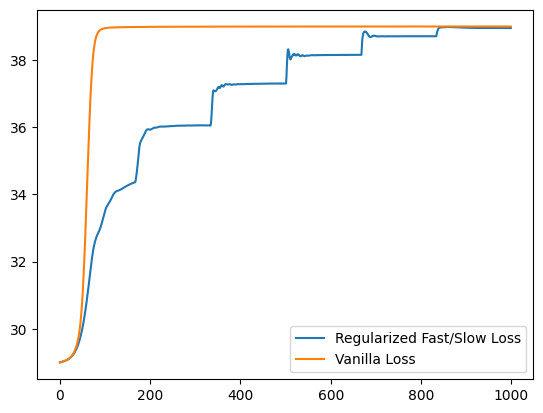

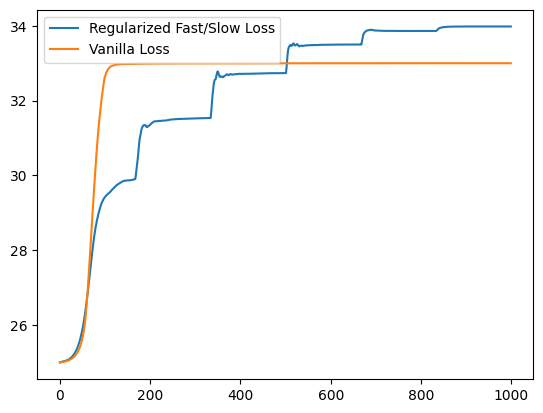

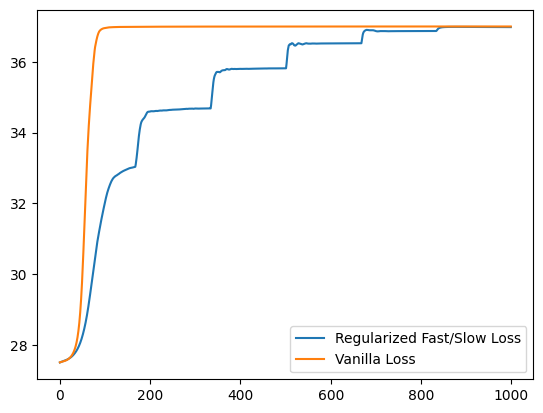

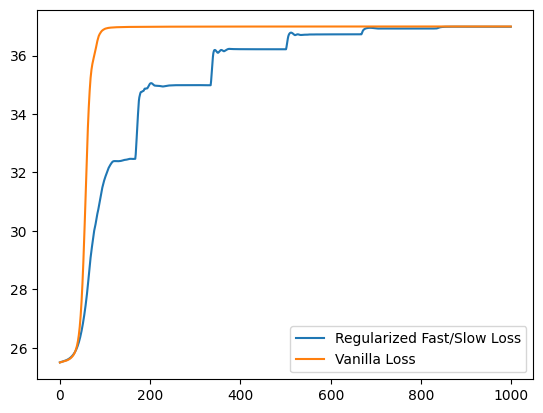

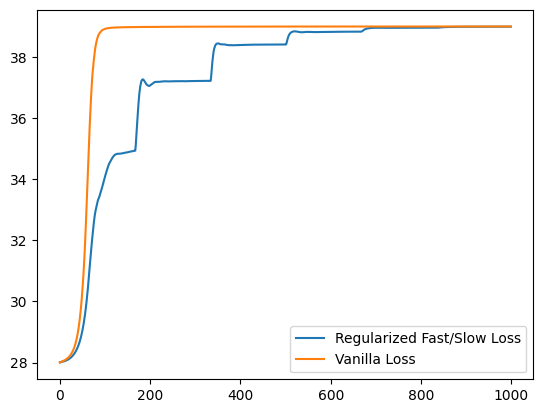

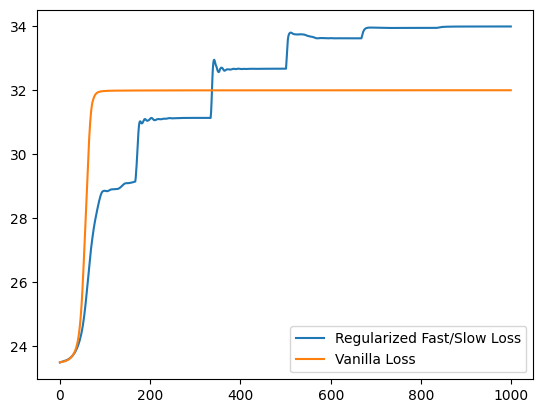

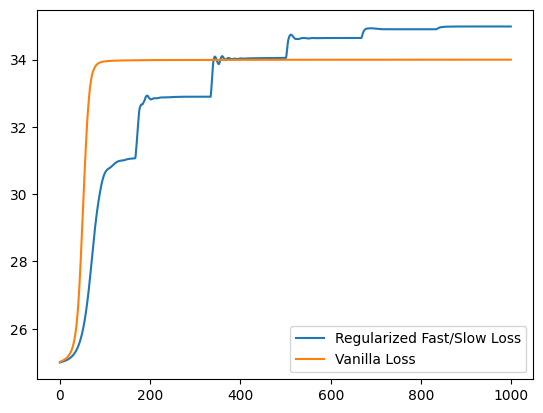

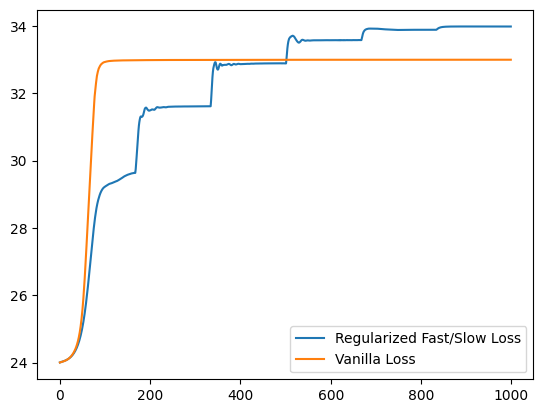

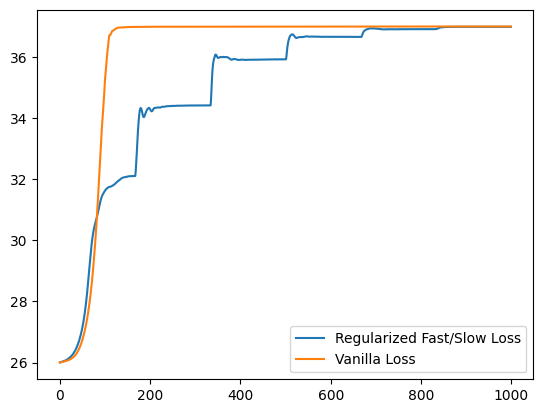

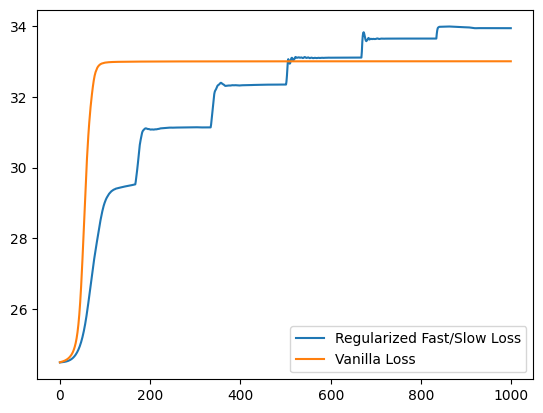

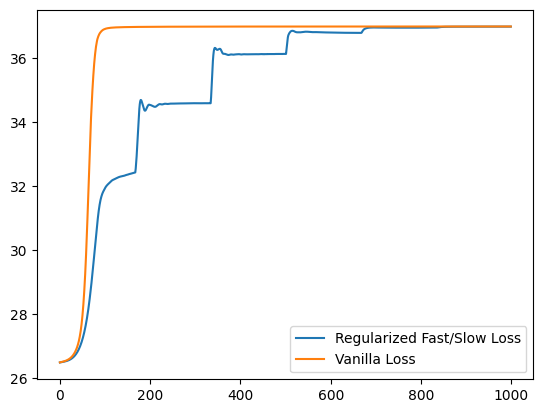

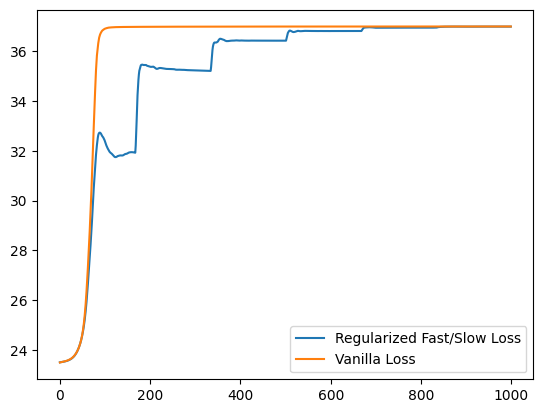

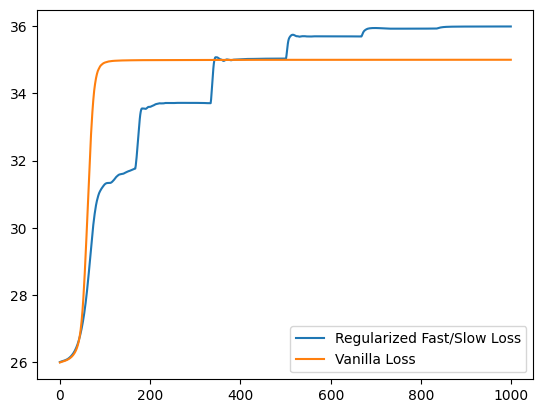

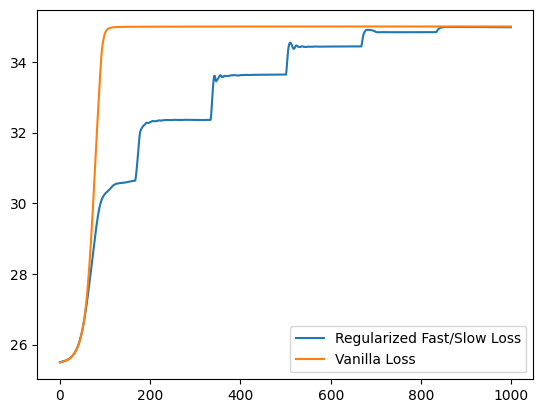

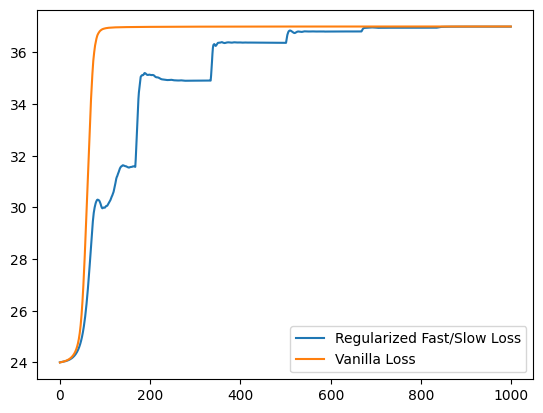

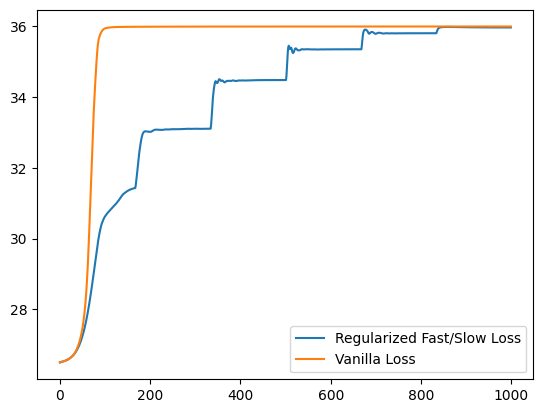

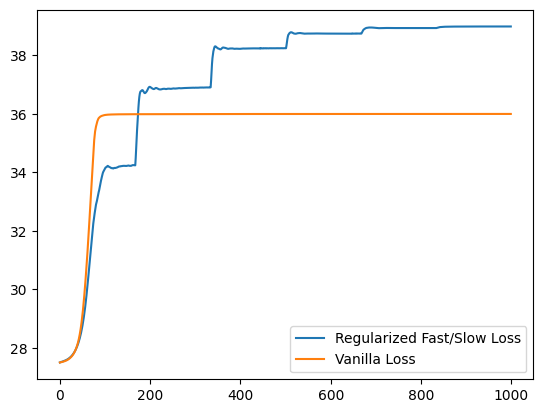

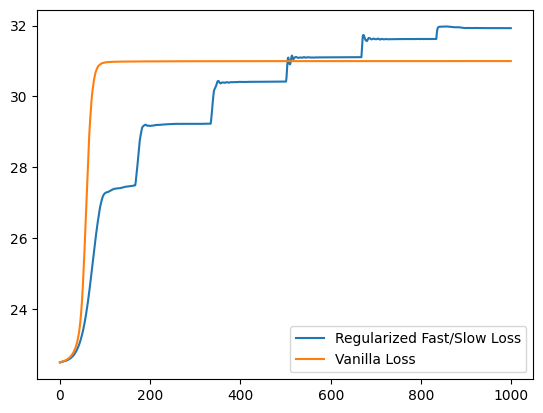

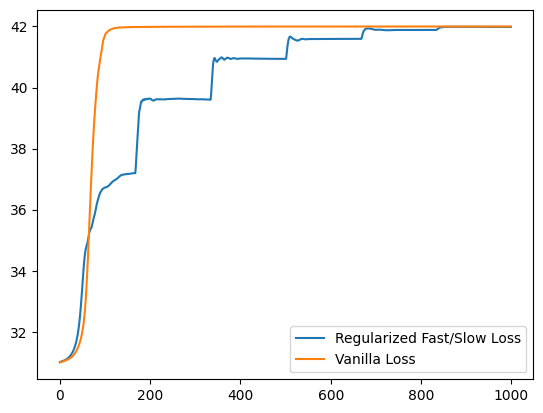

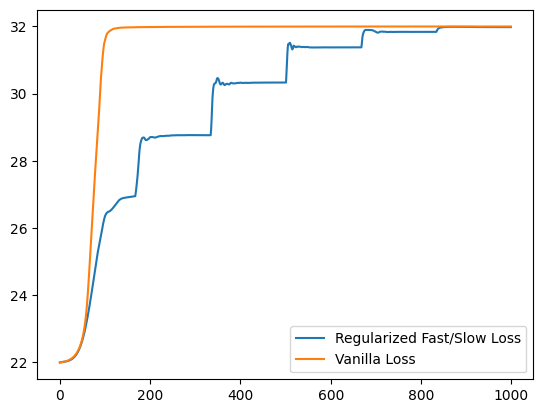

In [107]:
gen_trajectory_plots(reg_trajectories, vanilla_trajectories)

In [113]:
def successful_runs(opt_values, trajectories):
    num = 0
    total = 0
    for opt, trajectory in zip(opt_values, trajectories):
        results = np.array(trajectory)
        best_score = max(results)
        if abs(opt - best_score) < 0.95 :
            num = num + 1
        total = total + 1

    return (total, num)



In [114]:
successful_runs(torch.stack(optimal_values), vanilla_trajectories)

(20, 12)

In [115]:
successful_runs(torch.stack(optimal_values), reg_trajectories)

(20, 20)